# Flächenkartierung von Objekten in Kacheln

In diesem Notebook werden wir Zellkerne in Kacheln segmentieren und ihre Fläche messen. Anschließend speichern wir die resultierende Flächenkarte wieder als Kacheln in einer Zarr-Datei. Diese Strategie kann verwendet werden, um Daten zu verarbeiten, die als Ganzes nicht in den Arbeitsspeicher des Computers passen.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

Zu Demonstrationszwecken verwenden wir einen Datensatz, der von Theresa Suckert, OncoRay, Universitätsklinikum Carl Gustav Carus, TU Dresden, zur Verfügung gestellt wurde. Der Datensatz ist unter der [Lizenz: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) lizenziert. Wir verwenden hier eine zugeschnittene Version, die als 8-Bit-Bild neu gespeichert wurde, um sie mit dem Notebook bereitstellen zu können. Das vollständige 16-Bit-Bild im CZI-Dateiformat finden Sie [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ).

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# Zu Testzwecken beschneiden wir das Bild noch mehr.
# Kommentieren Sie die folgende Zeile aus, um es auf den gesamten 5000x2000 Pixeln auszuführen
image = image[1000:1500, 1000:1500]

# Komprimieren UND das Numpy-Array in ein Zarr-Array umwandeln
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Bild in Zarr-Array konvertieren
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# Zarr auf Festplatte speichern
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## Objektflächenkarten in Kacheln
Dask bietet integrierte Unterstützung für das Zarr-Dateiformat. Wir können Dask-Arrays direkt aus einer Zarr-Datei erstellen.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

Wir können die Bildverarbeitung direkt auf diesen gekachelten Datensatz anwenden.

In [4]:
def area_map(image):
    """
    Objekte in einem Binärbild markieren und ein Pixelzählkarten-Bild erstellen.
    """
    print("Verarbeite Bild der Größe", image.shape)
    
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    result = cle.pixel_count_map(labels)
    
    print(result.shape)
    
    return np.asarray(result)

## Testen der gekachelten Bildverarbeitung
Wir sollten unseren Flächenkartierungsalgorithmus an einer einzelnen Kachel testen. In einem realen Szenario wird der Bildverarbeitungs-Workflow tatsächlich auf einzelnen Kacheln entwickelt, z.B. in einem Notebook wie diesem. Sobald wir sicher sind, dass der Algorithmus funktioniert, können wir ihn auf alle Kacheln anwenden.

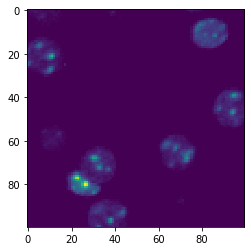

Processing image of size (100, 100)
(100, 100)


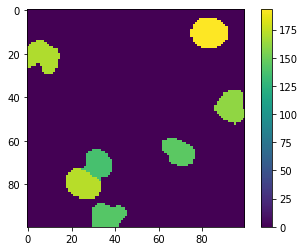

In [5]:
test_image = image[100:200,100:200]

imshow(test_image)

test_result = area_map(test_image)

imshow(test_result, colorbar=True)

## Anwendung der gekachelten Bildverarbeitung auf einen Zarr-basierten Datensatz

Die Anwendung der Funktion auf unseren Zarr-Datensatz wird ebenfalls ein Dask-Array ergeben.

In [6]:
overlap_width = 30

tile_map = da.map_overlap(area_map, zarr_image, depth=overlap_width, boundary=0)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


dask.array<_trim, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

Bevor wir mit der Berechnung beginnen können, müssen wir die asynchrone Ausführung von Operationen in pyclesperanto deaktivieren. [Siehe auch verwandtes Problem](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [7]:
cle.set_wait_for_kernel_finish(True)

Wenn wir das Speichern der Ergebnisse auf der Festplatte aufrufen, erfolgt die Verarbeitung auf einzelnen Kacheln.

In [8]:
processed_zarr_filename = '../../data/P1_H_C3H_M004_17-processed.zarr'

tile_map.to_zarr(processed_zarr_filename, overwrite=True)

Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size(160, 160) 
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)Processing image of sizeProcessing image of size(160, 160)
 (160, 160)
 
(160, 1

## Laden von Zarr
Nur zu Demonstrationszwecken werden wir das Zarr-basierte gekachelte Bild laden und visualisieren. Bei der Arbeit mit großen Datenmengen ist dieser Schritt möglicherweise nicht durchführbar.

In [9]:
zarr_result = da.from_zarr(processed_zarr_filename)
zarr_result

dask.array<from-zarr, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

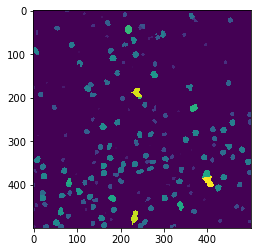

In [10]:
result = zarr_result.compute()

cle.imshow(result)